In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import librosa
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Initialization

In [ ]:
data = np.load('/content/drive/MyDrive/Major Assignment/Lmao/classical.npy')[:, :41712]

sc = MinMaxScaler()
max = np.max(np.abs(data))
data = data/max

x_train = data
print(x_train.shape)
x_train = torch.from_numpy(x_train).reshape(x_train.shape[0], 1, x_train.shape[1])
print(x_train.shape)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = x_train.shape[1]
latent_size = 4096
batch_size = 150
epochs = 30

(200, 41712)
torch.Size([200, 1, 41712])


In [ ]:
print(x_train[0])

tensor([[-0.0020,  0.0246,  0.0045,  ..., -0.0387, -0.0156, -0.0225]])


## Loss Functions

In [ ]:
L = nn.MSELoss()
def reproduction_loss(x, x_hat):
  return L(x_hat, x)

def KL_divergence(mean, log_var):
  return (-0.5)*torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

def total_loss(x_hat, x, mean, log_var):
    return reproduction_loss(x, x_hat) + KL_divergence(mean, log_var)

## Encoder Module

In [ ]:
class Encoder(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    self.Layer1 = nn.Conv1d(1, 64, 1024, stride=16)
    self.Layer2 = nn.Conv1d(64, 128, 512, stride=16)
    self.Layer3 = nn.Conv1d(128, 256, 128, stride=16)
    self.BN = nn.BatchNorm1d(256*1)

    self.LayerLM = nn.Linear(256*1, latent_size)
    self.LayerLV = nn.Linear(256*1, latent_size)

    self.tanh = nn.Tanh()
    self.flatten = nn.Flatten(start_dim=1)

  def forward(self, inp):
    x = self.tanh(self.Layer1(inp))
    x = self.tanh(self.Layer2(x))
    x = self.tanh(self.Layer3(x))
    x = self.flatten(x)
    x = self.BN(x)
    mean = self.LayerLM(x)
    var = self.LayerLV(x)

    return mean, var


## Decoder Module

In [ ]:
class Decoder(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    self.Layer1 = nn.Linear(latent_size, 256*1)
    self.Drop = nn.Dropout(0.7)
    self.Layer2 = nn.ConvTranspose1d(256, 128, 128, stride=16)
    self.Layer3 = nn.ConvTranspose1d(128, 64, 512, stride=16)
    self.Out = nn.ConvTranspose1d(64, 1, 1024, stride=16)

    self.tanh = nn.Tanh()
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256,1))

  def forward(self, inp):
    x = self.Layer1(inp)
    x = self.Drop(x)
    x = self.unflatten(x)
    x = self.tanh(self.Layer2(x))
    x = self.tanh(self.Layer3(x))
    x = self.tanh(self.Out(x))

    return x

## VAE Module

In [ ]:
class VAE(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    self.encoder = Encoder(latent_size)
    self.decoder = Decoder(latent_size)

  def reparameterization(self, mean, var):
    e = torch.randn(var.shape).to(device)
    return mean + var*e

  def forward(self, input):

    mean, var = self.encoder(input)
    output = self.decoder(self.reparameterization(mean, var))

    return mean, var, output

  def Train(self, Data_Train, epochs, optimizer):

    history_loss_train = []

    for epoch in range(epochs):

      train_loss = 0

      input = Data_Train.float().to(device)
      optimizer.zero_grad()

      mean, var, output = self(input)

      loss = total_loss(output, input, mean, var)
      loss.backward()
      optimizer.step()

      train_loss += torch.sum(loss).item()

      history_loss_train.append(train_loss/len(Data_Train))
      print(f'Epoch: [{epoch +1}/ {epochs}] loss:{history_loss_train[-1]} ' )
    return (history_loss_train)

## Training

In [ ]:
model = VAE( latent_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
history = model.Train(x_train, 200, optimizer)

Epoch: [1/ 200] loss:1098.558046875 
Epoch: [2/ 200] loss:2244.03890625 
Epoch: [3/ 200] loss:28629.795 
Epoch: [4/ 200] loss:26894.695 
Epoch: [5/ 200] loss:39156.51 
Epoch: [6/ 200] loss:49488.475 
Epoch: [7/ 200] loss:31748.2125 
Epoch: [8/ 200] loss:24366.265 
Epoch: [9/ 200] loss:11031.41125 
Epoch: [10/ 200] loss:8988.291875 
Epoch: [11/ 200] loss:8005.0325 
Epoch: [12/ 200] loss:7975.80125 
Epoch: [13/ 200] loss:6987.318125 
Epoch: [14/ 200] loss:5532.730625 
Epoch: [15/ 200] loss:4520.1821875 
Epoch: [16/ 200] loss:3819.3134375 
Epoch: [17/ 200] loss:3222.92 
Epoch: [18/ 200] loss:2719.0065625 
Epoch: [19/ 200] loss:2323.8528125 
Epoch: [20/ 200] loss:2024.92828125 
Epoch: [21/ 200] loss:1799.18078125 
Epoch: [22/ 200] loss:1626.15640625 
Epoch: [23/ 200] loss:1490.813125 
Epoch: [24/ 200] loss:1382.6953125 
Epoch: [25/ 200] loss:1294.59140625 
Epoch: [26/ 200] loss:1221.48453125 
Epoch: [27/ 200] loss:1159.821640625 
Epoch: [28/ 200] loss:1107.04046875 
Epoch: [29/ 200] loss:1

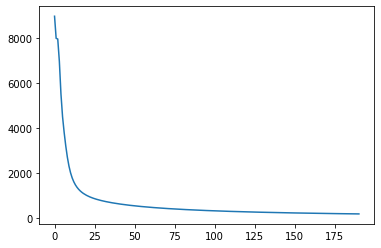

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(history[9:])), history[9:])
plt.show()

### Input Sample

In [ ]:
idx = 4
import IPython.display
sr = 3150
temp = x_train.reshape(x_train.shape[0], x_train.shape[2])
# temp = sc.inverse_transform(temp)
temp = temp*max
IPython.display.Audio(temp[idx], rate=sr)

### Generated Samples

In [ ]:
_, __, Gen = model(x_train.float().to(device))
temp = Gen.detach().to('cpu').reshape(x_train.shape[0], x_train.shape[2])
IPython.display.Audio(temp[idx], rate=sr)

In [ ]:
_, __, Gen = model(x_train.float().to(device))
temp = Gen.detach().to('cpu').reshape(x_train.shape[0], x_train.shape[2])
IPython.display.Audio(temp[idx+5], rate=sr)